In [1]:
%load_ext autoreload
%autoreload 2

# Getting Started 
Make sure your select ***ros_base*** as your kernel. You can do this by clicking on the kernel dropdown menu and selecting *ros_base*.


## Import Python dependencies

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, cm
from IPython.display import HTML
import numpy as np
import csv

import tqdm as tqdm


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from ILQR import RefPath
from ILQR import ILQR



In [3]:
def load_path(filepath: str):
    """
    Gets the centerline of the track from the trajectory data. We currently only
    support 2D track.

    Args:
        filepath (str): the path to file consisting of the centerline position.

    Returns:
        np.ndarray: centerline, of the shape (2, N).
    """
    x = []
    y = []
    with open(filepath) as f:
        spamreader = csv.reader(f, delimiter=',')
        for i, row in enumerate(spamreader):
            if i > 0:
                x.append(float(row[0]))
                y.append(float(row[1]))

    return np.array([x, y])

## Generate a reference trajectory

In [4]:
# Define the file paths
config_file = 'task1/task1.yaml'
track_path = 'task1/ref_path.csv'

# Load the reference path
x = []
y = []
left_width = []
right_width = []
with open(track_path, newline='') as f:
    spamreader = csv.reader(f, delimiter=',')
    for i, row in enumerate(spamreader):
        if i>0:
            x.append(float(row[0]))
            y.append(float(row[1]))
            left_width.append(float(row[3]))
            right_width.append(float(row[2]))
            
x = np.array(x)/30.0
y = np.array(y)/30.0
left_width = np.array(left_width)
right_width = np.array(right_width)
center_line = np.array([x,y])


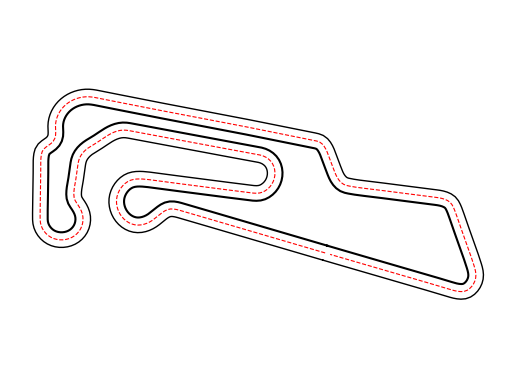

In [5]:
# Create a reference path
ref_path = RefPath(center_line, width_left = 0.6, width_right = 0.6, speed_limt = 5, loop = True)

# Visualize the reference path
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
plt.axis('equal')
_ = plt.axis('off')


## Test your ILQR planner
The planner need to warmup for a few steps for the first time it is run. This process will takes 10-30 seconds depending on your computer.

In [6]:
ilqr = ILQR(config_file)
ilqr.update_ref_path(ref_path)


Line Search Alphas:  [10.    1.    0.1   0.01]
ILQR setting: ILQR config: {'num_dim_x': 5, 'num_dim_u': 2, 'T': 10, 'dt': 0.1, 'platform': 'cpu', 'max_iter': 50, 'tol': 0.05, 'line_search_base': 0.1, 'line_search_a': -1, 'line_search_b': 3, 'line_search_c': 1, 'reg_min': '1e-5', 'reg_max': '1e8', 'reg_scale_down': 5, 'reg_scale_up': 5, 'reg_init': 1.0, 'max_attempt': 5, 'wheelbase': 0.257, 'radius': 0.13, 'width': 0.22, 'length': 0.4, 'delta_max': 0.35, 'delta_min': -0.35, 'v_max': 5.0, 'v_min': 0.0, 'omega_min': -6.0, 'omega_max': 6.0, 'a_max': 5.0, 'a_min': -5.0, 'v_ref': 5.0, 'dim_closest_pt_x': 0, 'dim_closest_pt_y': 1, 'dim_path_slope': 2, 'path_cost_type': 'quadratic', 'path_weight': 2.0, 'path_huber_delta': 2, 'vel_cost_type': 'quadratic', 'vel_weight': 0.2, 'vel_huber_delta': 1, 'dim_vel_limit': 3, 'vel_limit_a': 10.0, 'vel_limit_b': 1.0, 'heading_cost_type': 'quadratic', 'heading_weight': 1, 'heading_huber_delta': 1, 'lat_accel_thres': 6.0, 'lat_accel_a': 5.0, 'lat_accel_b': 2

### Plan for one step

Text(0.5, 1.0, 'Lateral Acceleration')

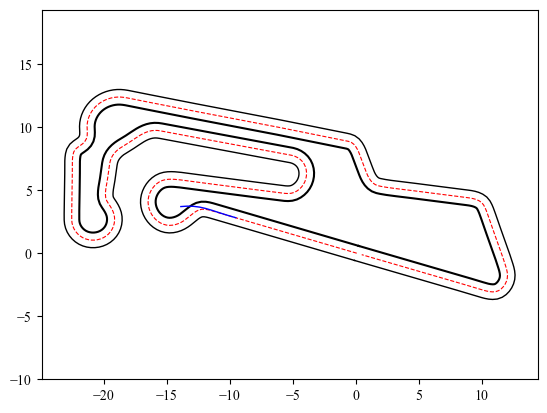

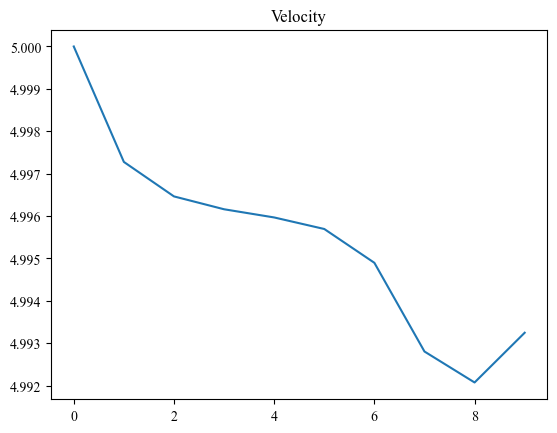

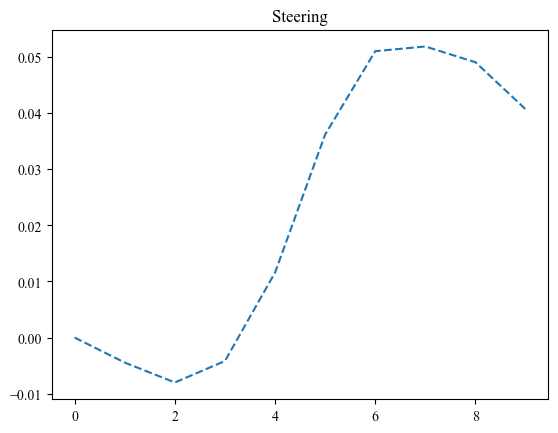

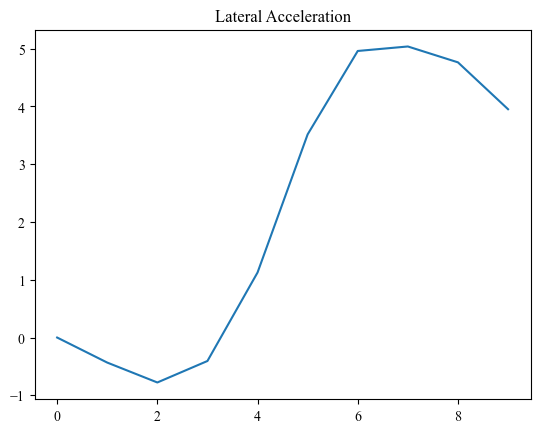

In [7]:
# Create an ILQR solver
x_init = np.array([x[60], y[60], 5, np.arctan2(y[61]-y[60], x[61]-x[60]), 0])
plan = ilqr.plan(x_init)

# Visualize the reference path
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
plt.plot(plan['trajectory'][0, :], plan['trajectory'][1, :], 'b-', linewidth=1)
plt.axis('equal')

plt.figure()
a = plan['trajectory'][2, :] 
plt.plot(a)
plt.title('Velocity')

plt.figure()
# plt.plot(plan['controls'][0,:])
plt.plot(plan['trajectory'][-1,:], '--')
plt.title('Steering')

plt.figure()
a = plan['trajectory'][2, :]**2 / 0.257 * np.tan(plan['trajectory'][-1, :])
plt.plot(a)
plt.title('Lateral Acceleration')


### Plan for the entire track

In [8]:
itr_receding = 400
init_control = np.zeros((2, ilqr.T))
x_cur = np.array([x[0], y[0], 4, np.arctan2(y[1]-y[0], x[1]-x[0]), 0])
state_history = np.zeros((5,itr_receding + 1))
state_history[:,0] = x_cur
plan_history = np.zeros((5, ilqr.T, itr_receding))
control_history = np.zeros((2,itr_receding))
t_process = np.zeros(itr_receding)
for i in (pbar := tqdm.tqdm(range(itr_receding))):
    plan = ilqr.plan(x_cur, init_control)
    
    trajectory = plan['trajectory']
    controls = plan['controls']
    
    # record the state and control
    state_history[:,i+1]  = trajectory[:,1]
    control_history[:,i] = controls[:,0]
    plan_history[:,:,i] = trajectory
    t_process[i] = plan['t_process']
    
    # prepare for next iteration
    x_cur = trajectory[:,1] 
    init_control[:,:-1] = controls[:,1:]
    
    pbar.set_description(f"ILQR takes : {plan['t_process']:.2f} sec']")

ILQR takes : 0.01 sec']:   2%|▏         | 8/400 [00:00<00:09, 39.75it/s]

converged after  2  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 


ILQR takes : 0.03 sec']:   6%|▌         | 22/400 [00:00<00:07, 48.18it/s]

converged after  0  steps. 
line search failed with reg =  0.2  at step  0
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
line search failed with reg =  0.2  at step  0
converged after  0  steps. 
converged after  0  steps. 
converged after  3  steps. 


ILQR takes : 0.04 sec']:   7%|▋         | 27/400 [00:00<00:09, 40.06it/s]

converged after  2  steps. 
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  4  steps. 


ILQR takes : 0.02 sec']:  11%|█▏        | 45/400 [00:01<00:08, 43.33it/s]

converged after  2  steps. 
converged after  2  steps. 
line search failed with reg =  0.008  at step  2
converged after  1  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  1  steps. 


ILQR takes : 0.04 sec']:  12%|█▎        | 50/400 [00:01<00:10, 32.87it/s]

converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  2  steps. 
converged after  3  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  3  steps. 


ILQR takes : 0.02 sec']:  15%|█▍        | 59/400 [00:01<00:09, 34.65it/s]

converged after  2  steps. 
converged after  2  steps. 
converged after  1  steps. 
converged after  2  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  0  steps. 


ILQR takes : 0.03 sec']:  17%|█▋        | 68/400 [00:01<00:09, 34.72it/s]

converged after  1  steps. 
converged after  1  steps. 
converged after  1  steps. 
line search failed with reg =  0.0016  at step  3
converged after  3  steps. 
converged after  3  steps. 


ILQR takes : 0.02 sec']:  20%|██        | 81/400 [00:02<00:09, 32.98it/s]

line search failed with reg =  0.0016  at step  3
converged after  2  steps. 
converged after  2  steps. 
line search failed with reg =  0.008  at step  2
line search failed with reg =  0.008  at step  2
converged after  1  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 


ILQR takes : 0.02 sec']:  22%|██▏       | 89/400 [00:02<00:10, 29.86it/s]

converged after  2  steps. 
line search failed with reg =  0.2  at step  0
converged after  0  steps. 
converged after  2  steps. 
converged after  2  steps. 
converged after  2  steps. 
converged after  1  steps. 


ILQR takes : 0.01 sec']:  25%|██▌       | 100/400 [00:02<00:07, 38.28it/s]

converged after  2  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 


ILQR takes : 0.01 sec']:  28%|██▊       | 111/400 [00:03<00:06, 42.23it/s]

converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  1  steps. 


ILQR takes : 0.01 sec']:  31%|███       | 123/400 [00:03<00:05, 48.39it/s]

line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps. 
converged after  0  steps. 
line search failed with reg =  0.2  at step  0
converged after  3  steps. 
converged after  0  steps. 
converged after  0  steps. 
line search failed with reg =  0.2  at step  0
converged after  0  steps. 


ILQR takes : 0.04 sec']:  32%|███▏      | 128/400 [00:03<00:05, 45.95it/s]

line search failed with reg =  0.2  at step  0
converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 


ILQR takes : 0.01 sec']:  34%|███▍      | 138/400 [00:03<00:07, 33.33it/s]

converged after  4  steps. 
converged after  3  steps. 
converged after  3  steps. 
converged after  2  steps. 
converged after  2  steps. 
converged after  2  steps. 
line search failed with reg =  0.008  at step  2
converged after  1  steps. 
converged after  1  steps. 
converged after  0  steps. 


ILQR takes : 0.03 sec']:  36%|███▌      | 143/400 [00:04<00:07, 36.01it/s]

converged after  0  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  2  steps. 


ILQR takes : 0.01 sec']:  38%|███▊      | 154/400 [00:04<00:06, 40.06it/s]

converged after  3  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  2  steps. 
converged after  1  steps. 
converged after  2  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  0  steps. 


ILQR takes : 0.01 sec']:  41%|████      | 164/400 [00:04<00:06, 35.73it/s]

converged after  3  steps. 
converged after  2  steps. 
converged after  3  steps. 
line search failed with reg =  0.2  at step  0


ILQR takes : 0.02 sec']:  42%|████▏     | 168/400 [00:04<00:07, 30.80it/s]

converged after  2  steps. 
converged after  0  steps. 
converged after  3  steps. 
converged after  1  steps. 
converged after  2  steps. 


ILQR takes : 0.01 sec']:  43%|████▎     | 172/400 [00:04<00:07, 28.96it/s]

converged after  4  steps. 
converged after  2  steps. 
converged after  3  steps. 
converged after  2  steps. 
line search failed with reg =  0.008  at step  2
converged after  1  steps. 
converged after  0  steps. 
line search failed with reg =  0.2  at step  0


ILQR takes : 0.01 sec']:  46%|████▌     | 183/400 [00:05<00:06, 34.32it/s]

converged after  3  steps. 
converged after  2  steps. 
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps. 
line search failed with reg =  0.0016  at step  3
line search failed with reg =  0.2  at step  0
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 


ILQR takes : 0.01 sec']:  50%|████▉     | 198/400 [00:05<00:04, 47.33it/s]

converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0


ILQR takes : 0.02 sec']:  51%|█████     | 204/400 [00:05<00:03, 49.74it/s]

line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps. 
converged after  0  steps. 


ILQR takes : 0.02 sec']:  54%|█████▍    | 215/400 [00:05<00:04, 39.02it/s]

converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  4  steps. 
converged after  3  steps. 


ILQR takes : 0.04 sec']:  55%|█████▌    | 220/400 [00:06<00:05, 35.94it/s]

converged after  2  steps. 
converged after  2  steps. 
converged after  0  steps. 
converged after  0  steps. 


ILQR takes : 0.01 sec']:  57%|█████▊    | 230/400 [00:06<00:04, 35.85it/s]

line search failed with reg =  0.00032  at step  4
converged after  4  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  2  steps. 
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps. 
line search failed with reg =  0.0016  at step  3
line search failed with reg =  0.2  at step  0
converged after  0  steps. 


ILQR takes : 0.03 sec']:  60%|██████    | 241/400 [00:06<00:04, 35.52it/s]

converged after  0  steps. 
converged after  0  steps. 
converged after  3  steps. 
converged after  4  steps. 
converged after  4  steps. 


ILQR takes : 0.04 sec']:  63%|██████▎   | 251/400 [00:06<00:04, 34.85it/s]

converged after  3  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  4  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 


ILQR takes : 0.01 sec']:  66%|██████▋   | 265/400 [00:07<00:03, 34.15it/s]

converged after  4  steps. 
line search failed with reg =  0.008  at step  2
converged after  1  steps. 
converged after  0  steps. 
line search failed with reg =  0.2  at step  0
converged after  1  steps. 
line search failed with reg =  0.008  at step  2
line search failed with reg =  0.2  at step  0
converged after  0  steps. 
converged after  0  steps. 
converged after  2  steps. 
converged after  0  steps. 


ILQR takes : 0.02 sec']:  69%|██████▉   | 276/400 [00:07<00:03, 40.03it/s]

converged after  1  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  1  steps. 


ILQR takes : 0.02 sec']:  70%|███████   | 281/400 [00:07<00:03, 39.28it/s]

converged after  2  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  2  steps. 


ILQR takes : 0.02 sec']:  72%|███████▎  | 290/400 [00:08<00:03, 32.78it/s]

converged after  1  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0


ILQR takes : 0.01 sec']:  76%|███████▌  | 304/400 [00:08<00:02, 46.35it/s]

line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 


ILQR takes : 0.02 sec']:  79%|███████▉  | 317/400 [00:08<00:01, 44.79it/s]

converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  2  steps. 


ILQR takes : 0.03 sec']:  80%|████████  | 322/400 [00:08<00:01, 39.40it/s]

line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0


ILQR takes : 0.01 sec']:  83%|████████▎ | 333/400 [00:08<00:01, 41.01it/s]

converged after  3  steps. 
converged after  2  steps. 
converged after  2  steps. 
line search failed with reg =  0.008  at step  2
converged after  1  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 


ILQR takes : 0.01 sec']:  86%|████████▌ | 344/400 [00:09<00:01, 38.85it/s]

converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  3  steps. 
converged after  0  steps. 


ILQR takes : 0.02 sec']:  87%|████████▋ | 349/400 [00:09<00:01, 37.89it/s]

converged after  0  steps. 
converged after  0  steps. 
converged after  2  steps. 
converged after  2  steps. 
converged after  2  steps. 
converged after  1  steps. 
converged after  2  steps. 
converged after  1  steps. 


ILQR takes : 0.03 sec']:  90%|████████▉ | 359/400 [00:09<00:01, 39.80it/s]

converged after  1  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  1  steps. 
converged after  0  steps. 
line search failed with reg =  0.0016  at step  3


ILQR takes : 0.04 sec']:  91%|█████████ | 364/400 [00:09<00:01, 35.32it/s]

converged after  3  steps. 
converged after  3  steps. 


ILQR takes : 0.02 sec']:  93%|█████████▎| 372/400 [00:10<00:00, 32.43it/s]

converged after  3  steps. 
converged after  2  steps. 
converged after  2  steps. 
line search failed with reg =  0.008  at step  2
line search failed with reg =  0.008  at step  2
converged after  1  steps. 


ILQR takes : 0.02 sec']:  94%|█████████▍| 376/400 [00:10<00:00, 28.90it/s]

converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  0  steps. 
converged after  2  steps. 


ILQR takes : 0.03 sec']:  96%|█████████▋| 385/400 [00:10<00:00, 31.98it/s]

line search failed with reg =  0.2  at step  0
converged after  0  steps. 
converged after  2  steps. 
converged after  2  steps. 
converged after  2  steps. 
converged after  2  steps. 
converged after  1  steps. 


ILQR takes : 0.01 sec']:  99%|█████████▉| 396/400 [00:10<00:00, 42.10it/s]

converged after  1  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 


ILQR takes : 0.01 sec']: 100%|██████████| 400/400 [00:10<00:00, 36.64it/s]


converged after  0  steps. 
converged after  1  steps. 
converged after  0  steps. 
converged after  0  steps. 


### Visualize the results

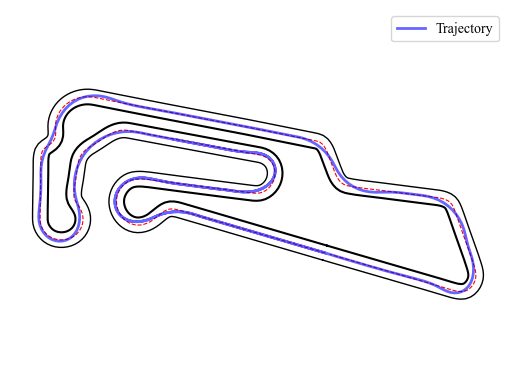

In [9]:
plt.figure()
plt.plot(state_history[0,:], state_history[1,:], 'b-', linewidth= 2, alpha =0.6, label = 'Trajectory')
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
plt.legend(prop={'size': 10})
plt.axis('equal')
plt.axis('off')
plt.show()

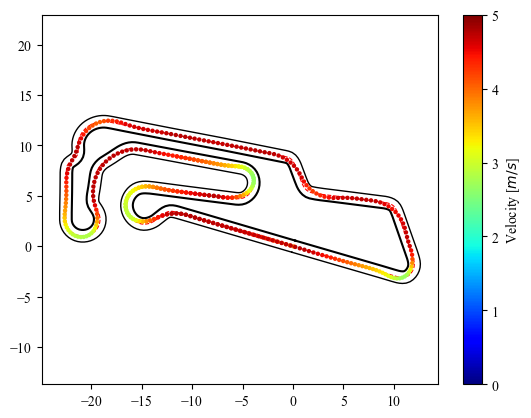

In [10]:
plt.figure()
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')

sc = plt.scatter(state_history[0, :-1], state_history[1,:-1], s = 10, 
                c=state_history[2,:-1], cmap=cm.jet, 
                vmin=0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(sc)
cbar.set_label(r"Velocity [$m/s$]", size=10)
plt.axis('equal')
plt.show()

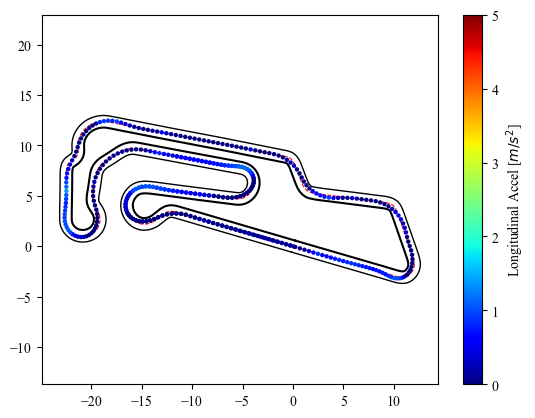

In [11]:
plt.figure()
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
sc = plt.scatter(state_history[0, :-1], state_history[1,:-1], s = 10, 
                c=control_history[0,:], cmap=cm.jet, 
                vmin=0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(sc)
cbar.set_label(r"Longitudinal Accel [$m/s^2$]", size=10)
plt.axis('equal')
plt.show()

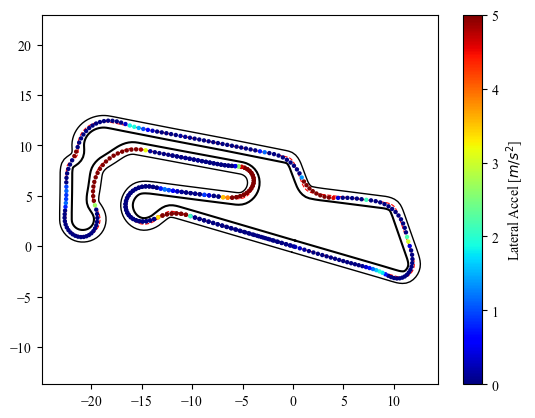

In [12]:
plt.figure()
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
alat = state_history[2,:]**2*np.tan(state_history[-1,:])/0.257
sc = plt.scatter(state_history[0, ], state_history[1,], s = 10, 
                c=alat, cmap=cm.jet, 
                vmin = 0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(sc)
cbar.set_label(r"Lateral Accel [$m/s^2$]", size=10)
plt.axis('equal')
plt.show()

In [13]:
sim = plt.figure()
ref_path.plot_track()
plan_plot = plt.plot([], [], linewidth= 2)[0]
traj_plot = plt.scatter([], [], s = 10, c=[], cmap=cm.jet, vmin=0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(traj_plot)
cbar.set_label(r"velocity [$m/s$]", size=20)
plt.axis('equal')
plt.close()

def drawframe(n):
    traj_plot.set_offsets(state_history[:2,:n+1].T)
    traj_plot.set_array(state_history[2,:n+1])
    plan_plot.set_data(plan_history[0,:, n], plan_history[1,:, n])
    
    return (traj_plot,plan_plot)


# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(sim, drawframe, frames=itr_receding, interval=ilqr.dt*1000, blit=True)
HTML(anim.to_html5_video())